## donwload

In [ ]:
!wget https://zenodo.org/records/3678171/files/dev_data_pump.zip?download=1 -O dev_data_pump.zip
!unzip dev_data_pump.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import shutil
import os

# Define the source path of the 'pump' folder
source_path = 'pump'

# Define the destination path within your mounted Google Drive
# Replace 'Your Drive Folder' with the actual folder name in your Google Drive where you want to copy
destination_path = '/content/drive/MyDrive/DATAs/pump_copied'

# Check if the destination path already exists and remove it if it does
if os.path.exists(destination_path):
    shutil.rmtree(destination_path)

# Use the shutil.copytree() function to copy the 'pump' folder
shutil.copytree(source_path, destination_path)

print(f"Folder '{source_path}' copied to '{destination_path}'")

## load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

base_path = '/content/drive/MyDrive/DATAs/pump_copied'
test_dir = os.path.join(base_path, 'test')
train_dir = os.path.join(base_path, 'train')

if os.path.exists(test_dir):
    print("OK")
else:
    print(f"Error: '{test_dir}' not found.")

if os.path.exists(train_dir):
    print("OK")
else:
    print(f"Error: '{train_dir}' not found.")

OK
OK


## install dependencies and imports

In [ ]:
!pip install librosa numpy scikit-learn matplotlib torch torchaudio tqdm

In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [ ]:
def extract_logmel(path, n_mels=64, sr=16000, hop_length=512):
    y, sr = librosa.load(path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    logmel = librosa.power_to_db(mel)
    return logmel.T  # (time, mel)

In [ ]:
def build_feature_dataset(directory, label=None):
    X, y = [], []
    for file in tqdm(sorted(os.listdir(directory))):
        if file.endswith(".wav"):
            fpath = os.path.join(directory, file)
            feat = extract_logmel(fpath)
            # Flatten mean & std per mel band
            features = np.hstack([feat.mean(axis=0), feat.std(axis=0)])
            X.append(features)
            if label is not None:
                y.append(label)
    return np.array(X), (np.array(y) if label is not None else None)

In [ ]:
# Load train (normal) data
X_train, _ = build_feature_dataset(train_dir, label=0)

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

print("Train shape:", X_train.shape)

100%|██████████| 3349/3349 [02:56<00:00, 18.99it/s]

Train shape: (3349, 128)


## model

In [ ]:
# --- 4. Autoencoder Model (Simple Dense) ---
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

input_dim = X_train.shape[1]
model = Autoencoder(input_dim)

In [ ]:
# --- 5. Training ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

X_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
batch_size = 32

In [ ]:
for epoch in range(20):
    perm = torch.randperm(X_tensor.size(0))
    epoch_loss = 0
    for i in range(0, X_tensor.size(0), batch_size):
        batch = X_tensor[perm[i:i+batch_size]]
        recon = model(batch)
        loss = criterion(recon, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss {epoch_loss:.4f}")

Epoch 1, Loss 66.3721
Epoch 2, Loss 36.6923
Epoch 3, Loss 28.7554
Epoch 4, Loss 25.8311
Epoch 5, Loss 23.8367
Epoch 6, Loss 22.2743
Epoch 7, Loss 21.0698
Epoch 8, Loss 20.2480
Epoch 9, Loss 19.5139
Epoch 10, Loss 18.9709
Epoch 11, Loss 18.5203
Epoch 12, Loss 18.0976
Epoch 13, Loss 17.7461
Epoch 14, Loss 17.4742
Epoch 15, Loss 17.1759
Epoch 16, Loss 16.9008
Epoch 17, Loss 16.6376
Epoch 18, Loss 16.4142
Epoch 19, Loss 16.2481
Epoch 20, Loss 16.0930


## test

In [ ]:
# --- 6. Test & Anomaly Scoring ---
# Build test features (both normal and anomaly)
X_test, y_test = [], []
for label, subdir in enumerate(["normal", "anomaly"]):
    X, y = build_feature_dataset(os.path.join(test_dir, subdir), label=label)
    X_test.append(X)
    y_test.append(y)

X_test = np.vstack(X_test)
y_test = np.concatenate(y_test)
X_test = scaler.transform(X_test)

# Compute reconstruction errors
model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    recon = model(X_tensor)
    errors = ((X_tensor - recon)**2).mean(dim=1).cpu().numpy()

# Normalize errors for visualization
threshold = np.percentile(errors, 95)  # Top 5% as anomaly
preds = (errors > threshold).astype(int)

100%|██████████| 456/456 [00:16<00:00, 28.49it/s]


ROC AUC: 0.7314144736842105


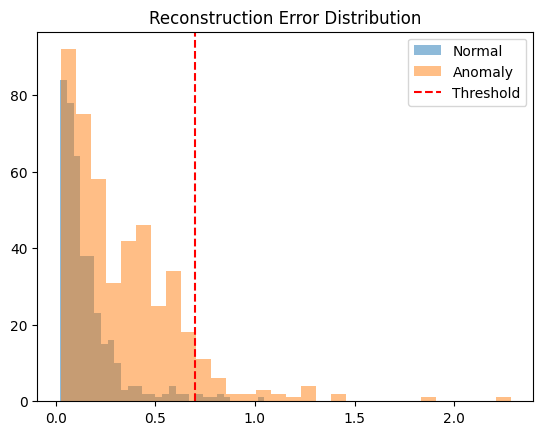

In [ ]:
# --- 7. Evaluation ---
auc = roc_auc_score(y_test, errors)
print("ROC AUC:", auc)

plt.hist(errors[y_test==0], bins=30, alpha=0.5, label="Normal")
plt.hist(errors[y_test==1], bins=30, alpha=0.5, label="Anomaly")
plt.axvline(threshold, color="red", linestyle="--", label="Threshold")
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()